In [1]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from root_pandas import read_root
%run functions.ipynb
%run constants.ipynb

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.
Welcome to JupyROOT 6.14/06


In [2]:
def getData(inputFiles):
    
    cols = []
    scalar = []
    scalar.append('evid')
    scalar.append('xsec')
    scalar.append('ntrials')    
    scalar.append('x')
    scalar.append('y')
    scalar.append('Q2')
    scalar.append('W2')
    
    scalar.append('eta_jet')
    scalar.append('p_jet')
    scalar.append('theta_jet')
    scalar.append('phi_jet')
    
    scalar.append('eta_quark')
    scalar.append('p_quark')
    scalar.append('theta_quark')
    
    scalar.append('eta_electron')
    scalar.append('p_electron')
    scalar.append('theta_electron')  
    scalar.append('phi_photon')
    lists = scalar
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists,flatten=cols)
        dataframes.append(df)
        end = time.time()
        print 'Processed', inputFilename, 'in',  end-start, 'seconds'
    return pd.concat([x for x in dataframes])

In [3]:
files = ["$HOME/fjpythia/output/723.root"]
a = getData(files)

# general cuts
d = applyCut(a, 'y > 0.01 and y < 0.85', '0.01 < y < 0.85')
d = applyCut(d, 'W2 > 4', 'W2 > 4')
d.eval('theta_jet_neg = 6.28318530718 - theta_jet', inplace = True)

d = fixPhi(d, 'photon')

# jet cut
df1 = applyCut(d, 'p_jet > 5', 'p_jet > 5')

# correlation cuts
df2 = applyCut(df1, 'delta_phi_photon_abs < 0.4', 'delta_phi_photon_abs < 0.4')

# quark cut
df3 = keepOneJet(d)
df3.eval('theta_quark_neg = 6.28318530718 - theta_quark', inplace = True)

ds_jet_uncut = applyCuts(df1, xedges, Q2edges)
ds_jet_cut = applyCuts(df2, xedges, Q2edges)
ds_quark = applyCuts(df3, xedges, Q2edges)

Processed $HOME/fjpythia/output/723.root in 110.816212177 seconds
0.01 < y < 0.85 28989288  fraction kept: 66.1
W2 > 4 28989288  fraction kept: 100.0
Fixed photon phi range
Fixed photon delta phi range
p_jet > 5 5077979  fraction kept: 17.5
delta_phi_photon_abs < 0.4 1350470  fraction kept: 26.6

Remove extra jets 5425935  fraction kept: 18.7

1 < Q2 < 10 GeV2 

1 < Q2 < 10 3945850  fraction kept: 77.7
0.008 < x < 0.01 312708  fraction kept: 7.9
0.01 < x < 0.05 1490835  fraction kept: 37.8
0.05 < x < 0.1 154921  fraction kept: 3.9
0.1 < x < 0.5 8062  fraction kept: 0.2

10 < Q2 < 25 GeV2 

10 < Q2 < 25 699386  fraction kept: 13.8
0.008 < x < 0.01 31696  fraction kept: 4.5
0.01 < x < 0.05 234690  fraction kept: 33.6
0.05 < x < 0.1 130010  fraction kept: 18.6
0.1 < x < 0.5 107417  fraction kept: 15.4

25 < Q2 < 100 GeV2 

25 < Q2 < 100 371238  fraction kept: 7.3
0.008 < x < 0.01 16260  fraction kept: 4.4
0.01 < x < 0.05 149115  fraction kept: 40.2
0.05 < x < 0.1 70044  fraction kept: 18.

In [31]:
def subplot(Q2Index, xIndex, r_low, theta_low, part_low, r_high, theta_high, color):
    
    if xIndex == 3:
        radii = radii_large
        r_labels = r_labels_large
        nr = nr_large
    else:
        radii = radii_small
        r_labels = r_labels_small
        nr = nr_small
    r_edges = np.linspace(0, nr, nr + 1)
    theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
    H_e = plt.hist2d(r_high, theta_high, [r_edges, theta_edges])[0]
    H_q = plt.hist2d(r_low, theta_low, [r_edges, theta_edges])[0]
    plt.cla()

    Theta, R = np.meshgrid(theta_edges, r_edges)
    plt.pcolormesh(Theta, R, H_e, cmap='Blues',norm=LogNorm())
    plt.colorbar(shrink=0.5, label='Counts (electron)')
    plt.pcolormesh(Theta, R, H_q, cmap=color, norm=LogNorm())
    plt.colorbar(shrink=0.5, label='Counts ('+part_low+')')
    plt.xlabel('$p^{'+part_low+'}(GeV)$ vs $\eta^{'+part_low+'}$', fontsize=15)
    plt.rgrids(radii, labels=r_labels, fontsize=12)
    plt.thetagrids(angles, labels=eta_labels, fontsize=12)
    plt.grid(color='grey')

In [50]:
def plot(Q2Index, xIndex, Q2Str, xStr, txt):
    
    fig = plt.figure(figsize=(24,20))
    plt.subplots_adjust(wspace=0, hspace=0)
    
    plt.subplot(221, polar=True)
    df_jet = ds_jet_uncut[Q2Index][xIndex]
    df_e = keepOneJet(df_jet)
    subplot(Q2Index, xIndex, df_jet['p_jet'], df_jet['theta_jet_neg'], 'jet', df_e['p_electron'], df_e['theta_electron'], 'Reds')
    plt.title('Cuts: $p^{jet} > 5 GeV$ \n' + xStr + ',$' + Q2Str + 'GeV^2$ \n $p^{electron}(GeV)$ vs $\eta^{electron}$', fontsize=15)
   
    plt.subplot(222, polar=True)
    df_jet = ds_jet_cut[Q2Index][xIndex]
    df_e = keepOneJet(df_jet)
    subplot(Q2Index, xIndex, df_jet['p_jet'], df_jet['theta_jet_neg'], 'jet', df_e['p_electron'], df_e['theta_electron'], 'Reds')
    plt.title('Cuts: $p^{jet} > 5 GeV, |\phi^{photon} - \phi^{jet}| < 0.4$ \n' + xStr + ',$' + Q2Str + 'GeV^2$ \n $p^{electron}(GeV)$ vs $\eta^{electron}$', fontsize=15)
    
    plt.subplot(223, polar=True)
    df = ds_quark[Q2Index][xIndex]
    subplot(Q2Index, xIndex, df['p_quark'], df['theta_quark_neg'], 'quark', df['p_electron'], df['theta_electron'],'Purples')
    plt.title('Cuts:' + xStr + ',$' + Q2Str + 'GeV^2$ \n $p^{electron}(GeV)$ vs $\eta^{electron}$', fontsize=15)
    
    #plt.subplot(224, polar=True)
    #df_part = ds_part[Q2Index][xIndex]
    #df_e = keepOneJet(df_part)
    #print df_e.shape[0]
    #subplot(Q2Index, xIndex, df_part['p_part'], df_part['theta_part_neg'], 'particle', df_e['p_electron'], df_e['theta_electron'])
    #plt.title('Cuts:' + xStr + ',$' + Q2Str + 'GeV^2$ \n $p^{electron}(GeV)$ vs $\eta^{electron}$', fontsize=15)
    
    plt.savefig('images/'+txt+'.png', bbox_inches='tight')

In [51]:
import numpy as np
radii_small = [0, 5, 10, 15, 20, 25]
r_labels_small = ['0','5','10','15','20', '25']
radii_large = [0, 10, 20, 30, 40, 50, 60, 70, 80]
r_labels_large = ['0','10','20','30','40','50','60','70','80']
angles = [90, 139.604937421, 164.585373193, 174.299529125, 177.90141703, 180, 182.09858297, 185.700470875, 195.414626807,
          220.395062579, 270, 319.604937421, 344.585373193, 354.299529125, 357.90141703, 360]
eta_labels = ['0','-1','-2','-3','-4','$-\infty$','-4','-3','-2','-1','0','1','2','3','4', '$\infty$']
nr_small = 25
nr_large = 80
ntheta = 240


Remove extra jets 211113  fraction kept: 67.5

Remove extra jets 57383  fraction kept: 97.3


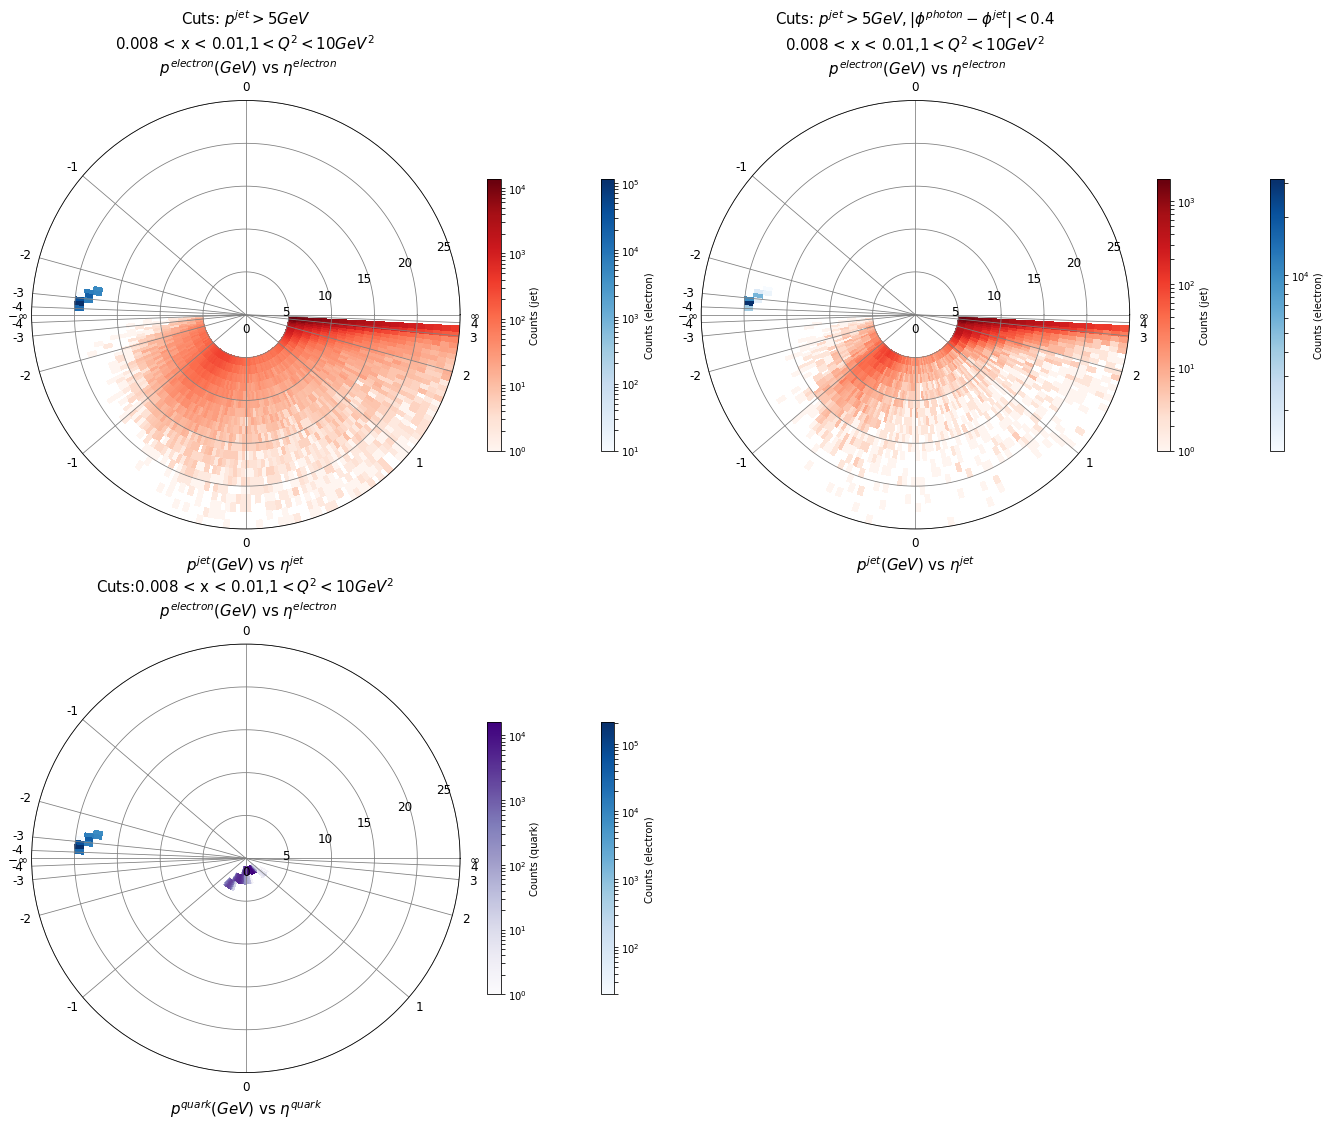

In [52]:
plot(0, 0, '1 < Q^2 < 10', '0.008 < x < 0.01', '1-10-008-01')


Remove extra jets 972687  fraction kept: 65.2

Remove extra jets 360513  fraction kept: 96.7


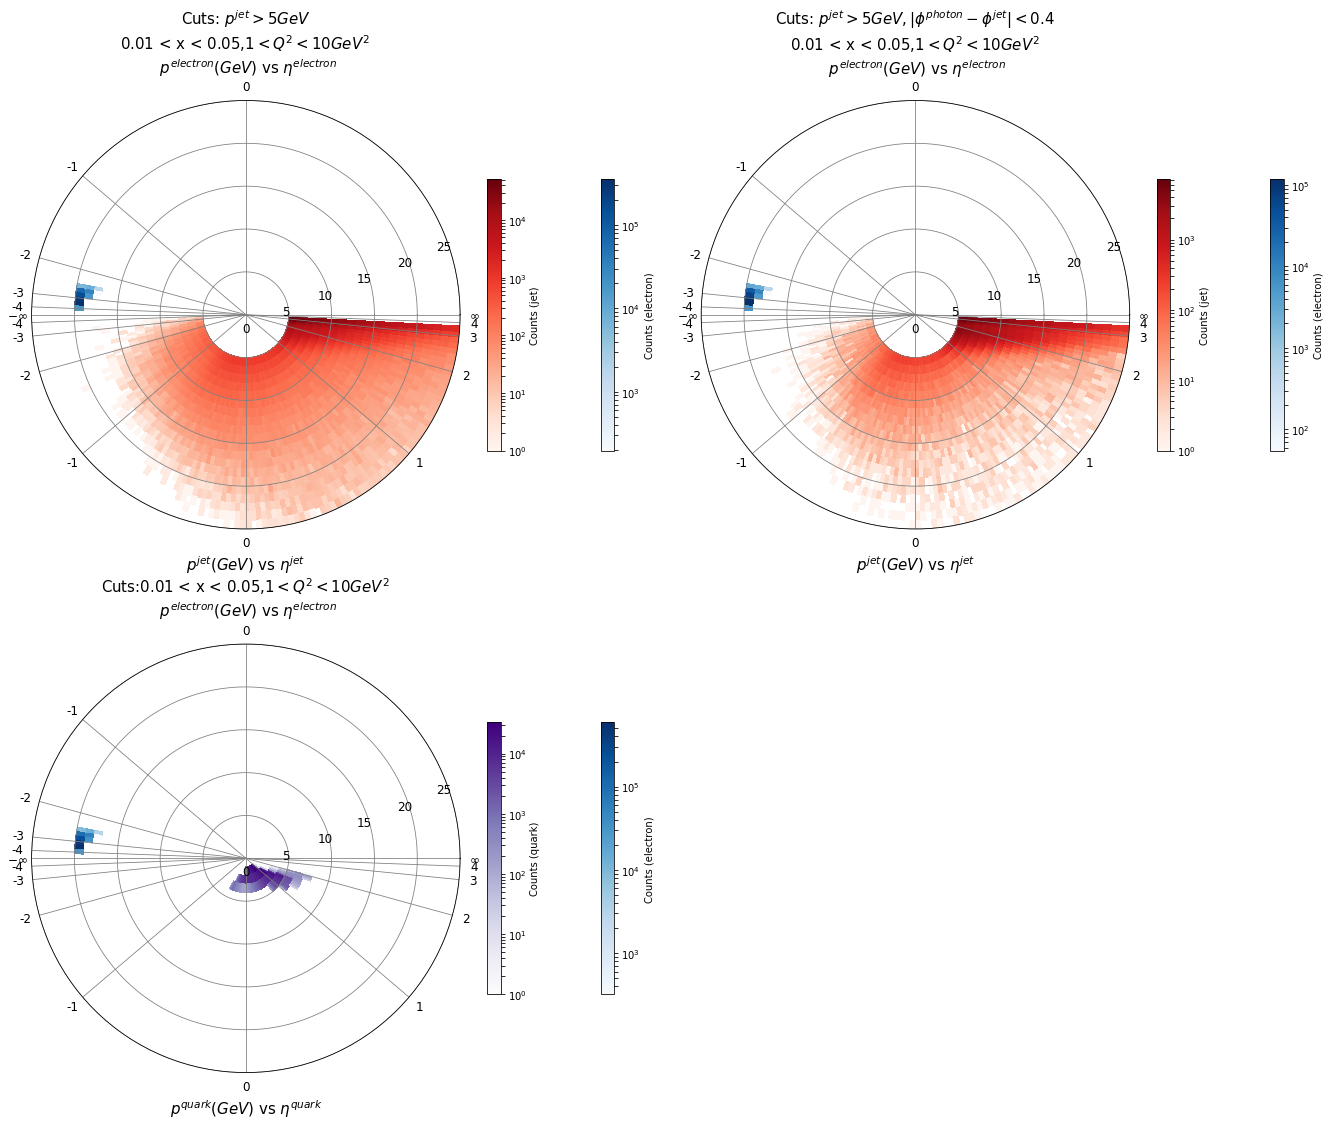

In [53]:
plot(0, 1, '1 < Q^2 < 10', '0.01 < x < 0.05', '1-10-01-05')


Remove extra jets 94521  fraction kept: 61.0

Remove extra jets 56978  fraction kept: 95.3


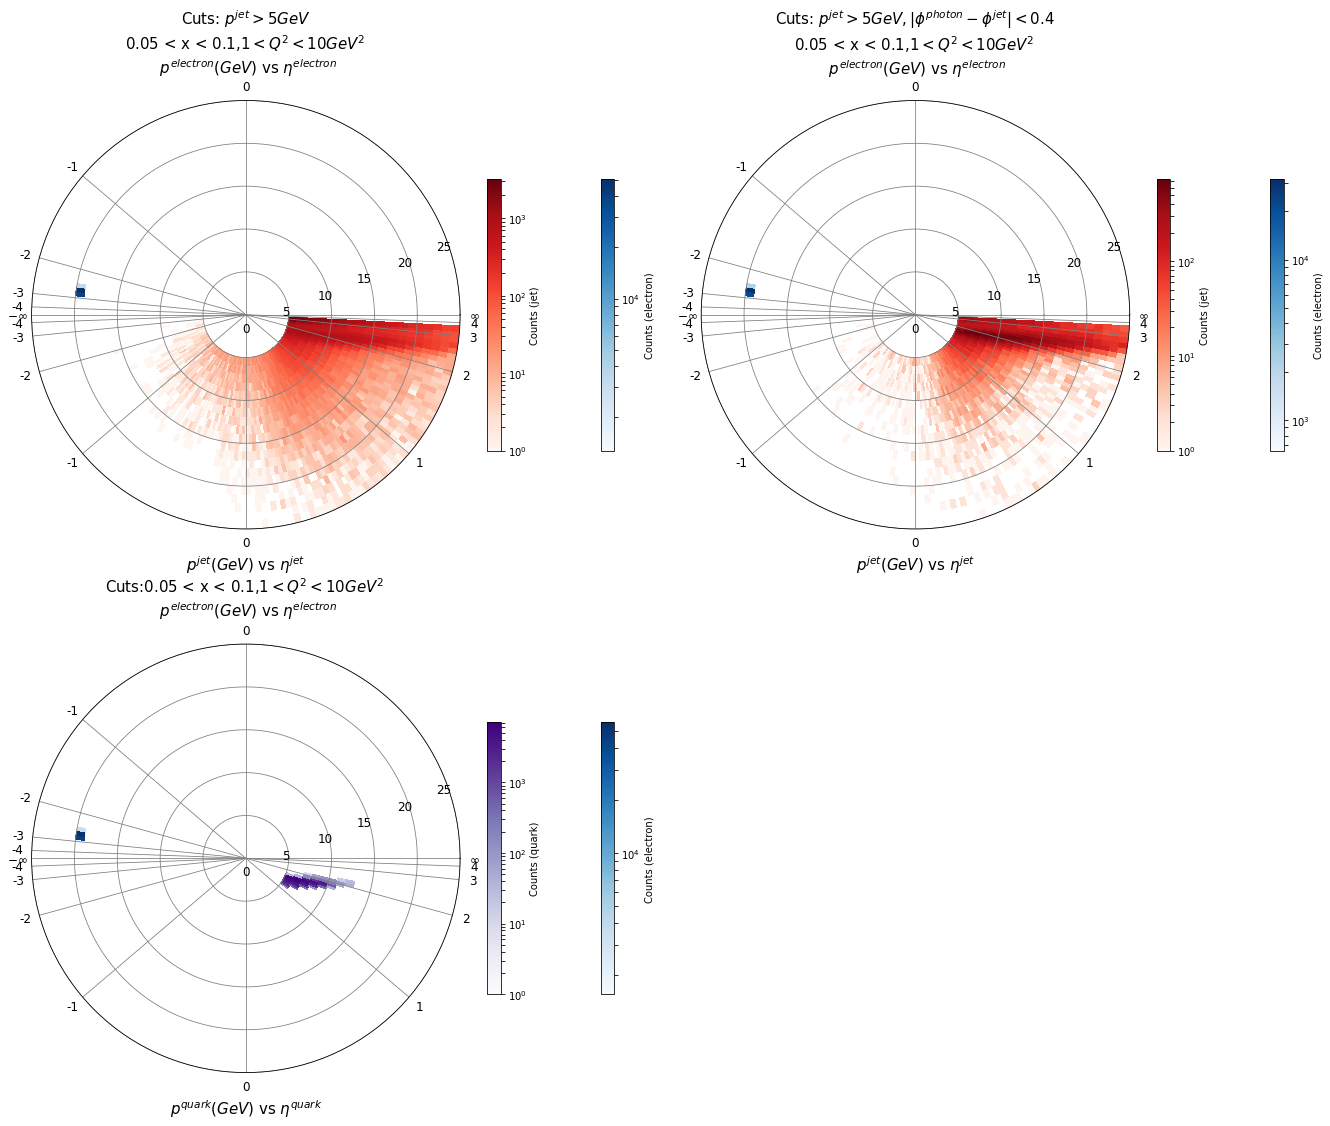

In [54]:
plot(0, 2, '1 < Q^2 < 10', '0.05 < x < 0.1', '1-10-05-1')


Remove extra jets 4926  fraction kept: 61.1

Remove extra jets 3366  fraction kept: 95.4


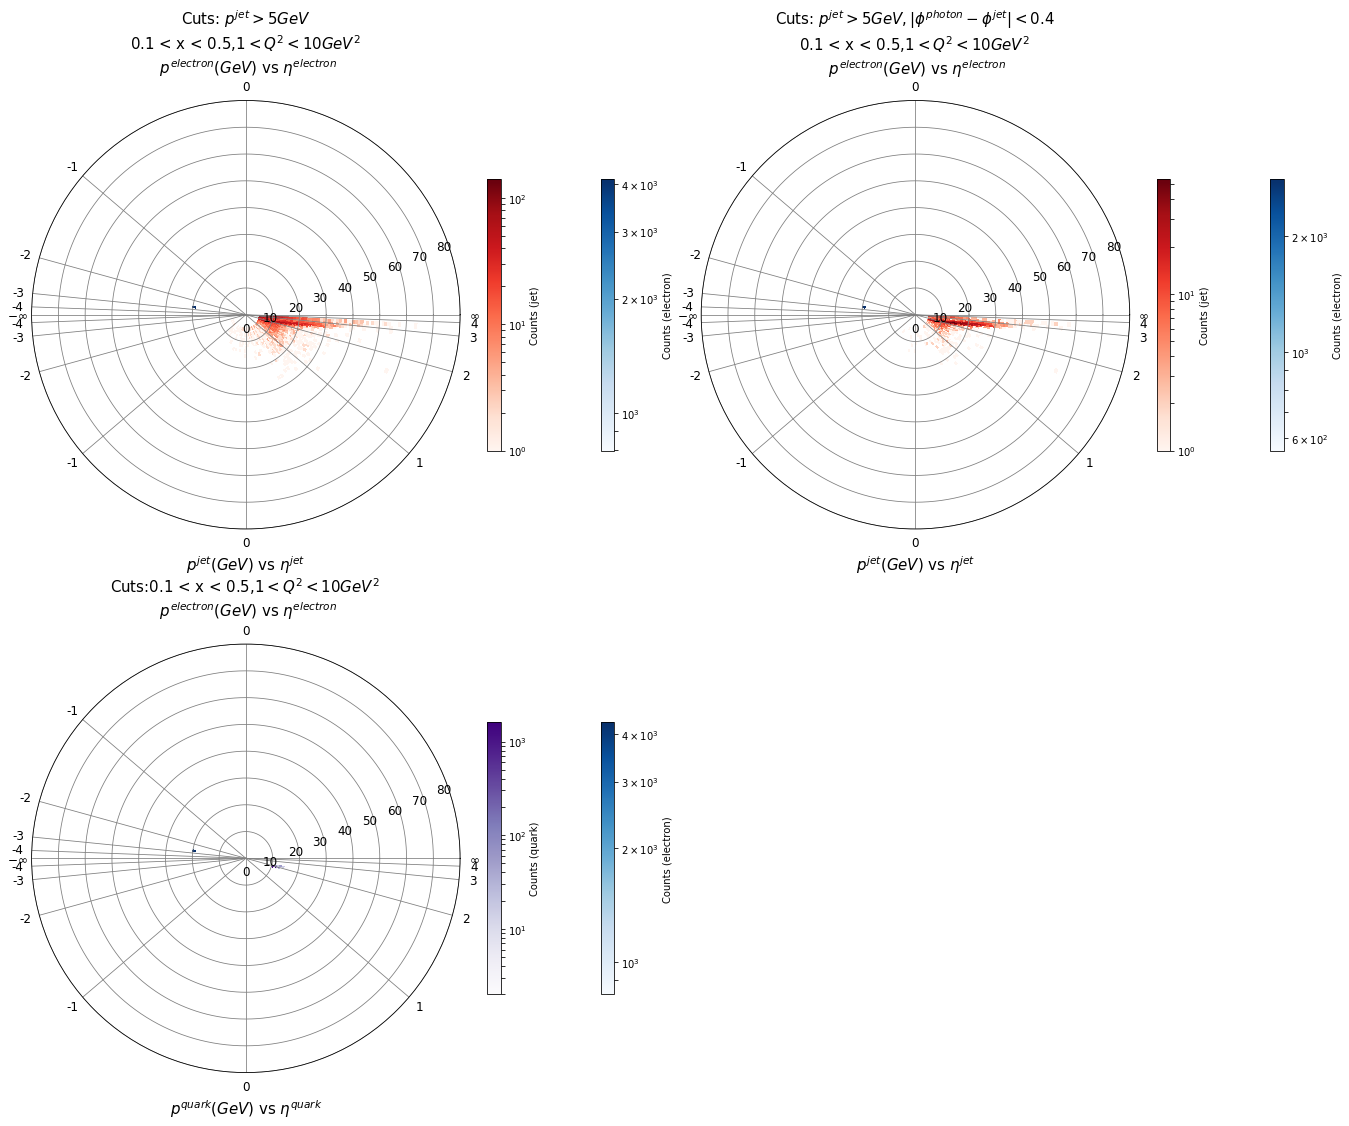

In [55]:
plot(0, 3, '1 < Q^2 < 10', '0.1 < x < 0.5', '1-10-1-5')


Remove extra jets 20019  fraction kept: 63.2

Remove extra jets 8670  fraction kept: 94.6


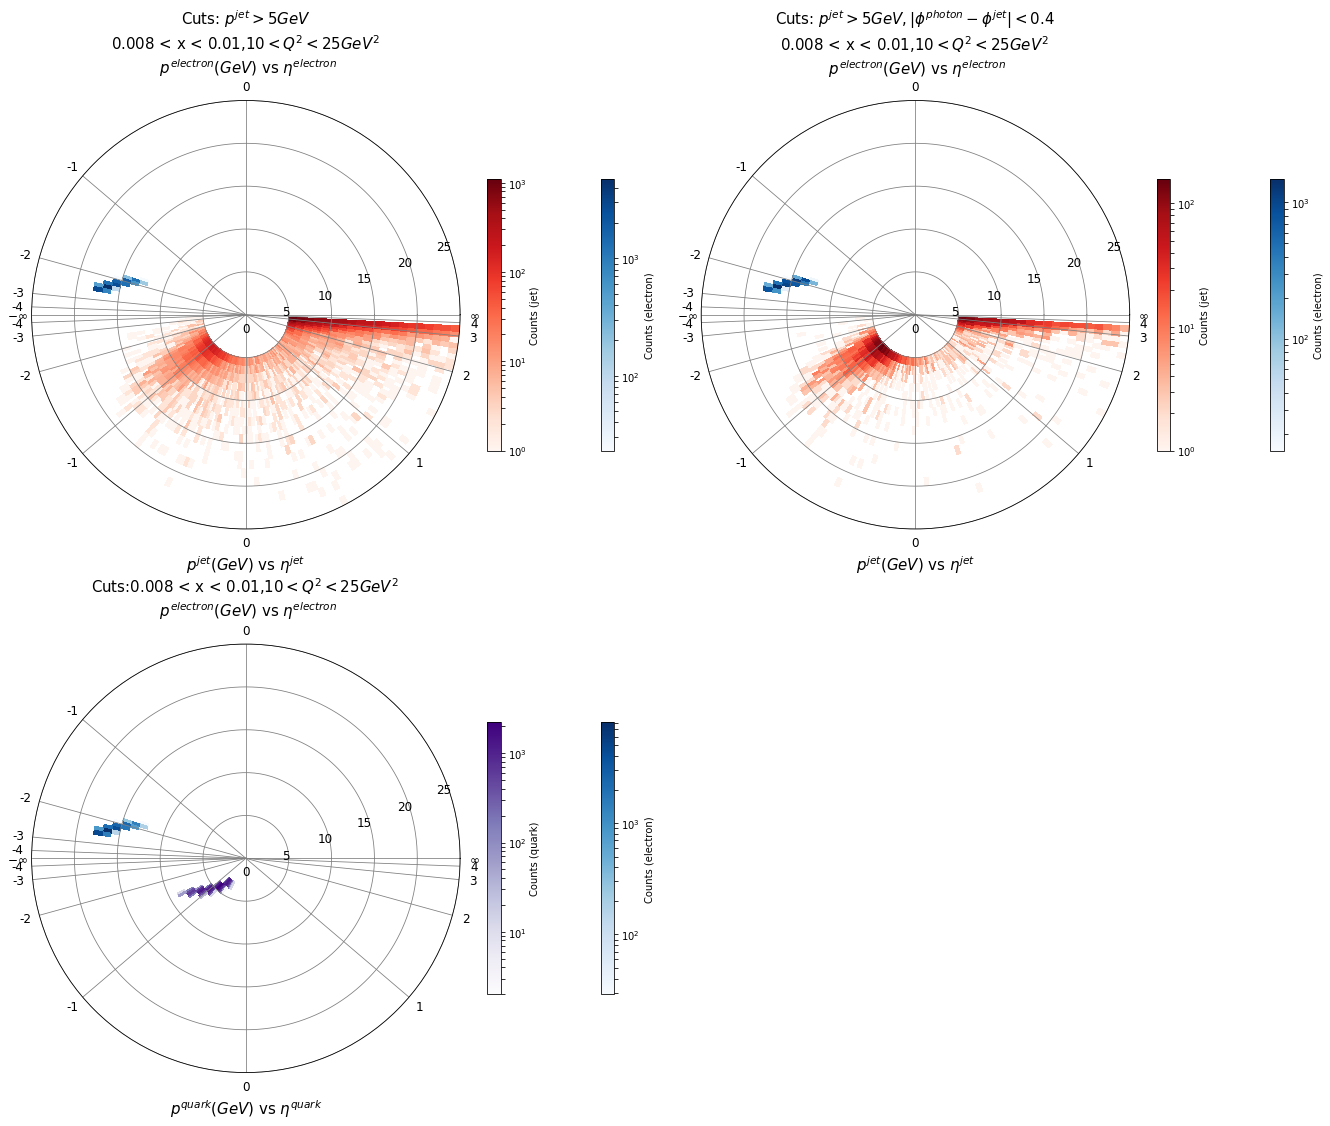

In [56]:
plot(1, 0, '10 < Q^2 < 25', '0.008 < x < 0.01', '10-25-008-01')


Remove extra jets 144570  fraction kept: 61.6

Remove extra jets 70077  fraction kept: 94.5


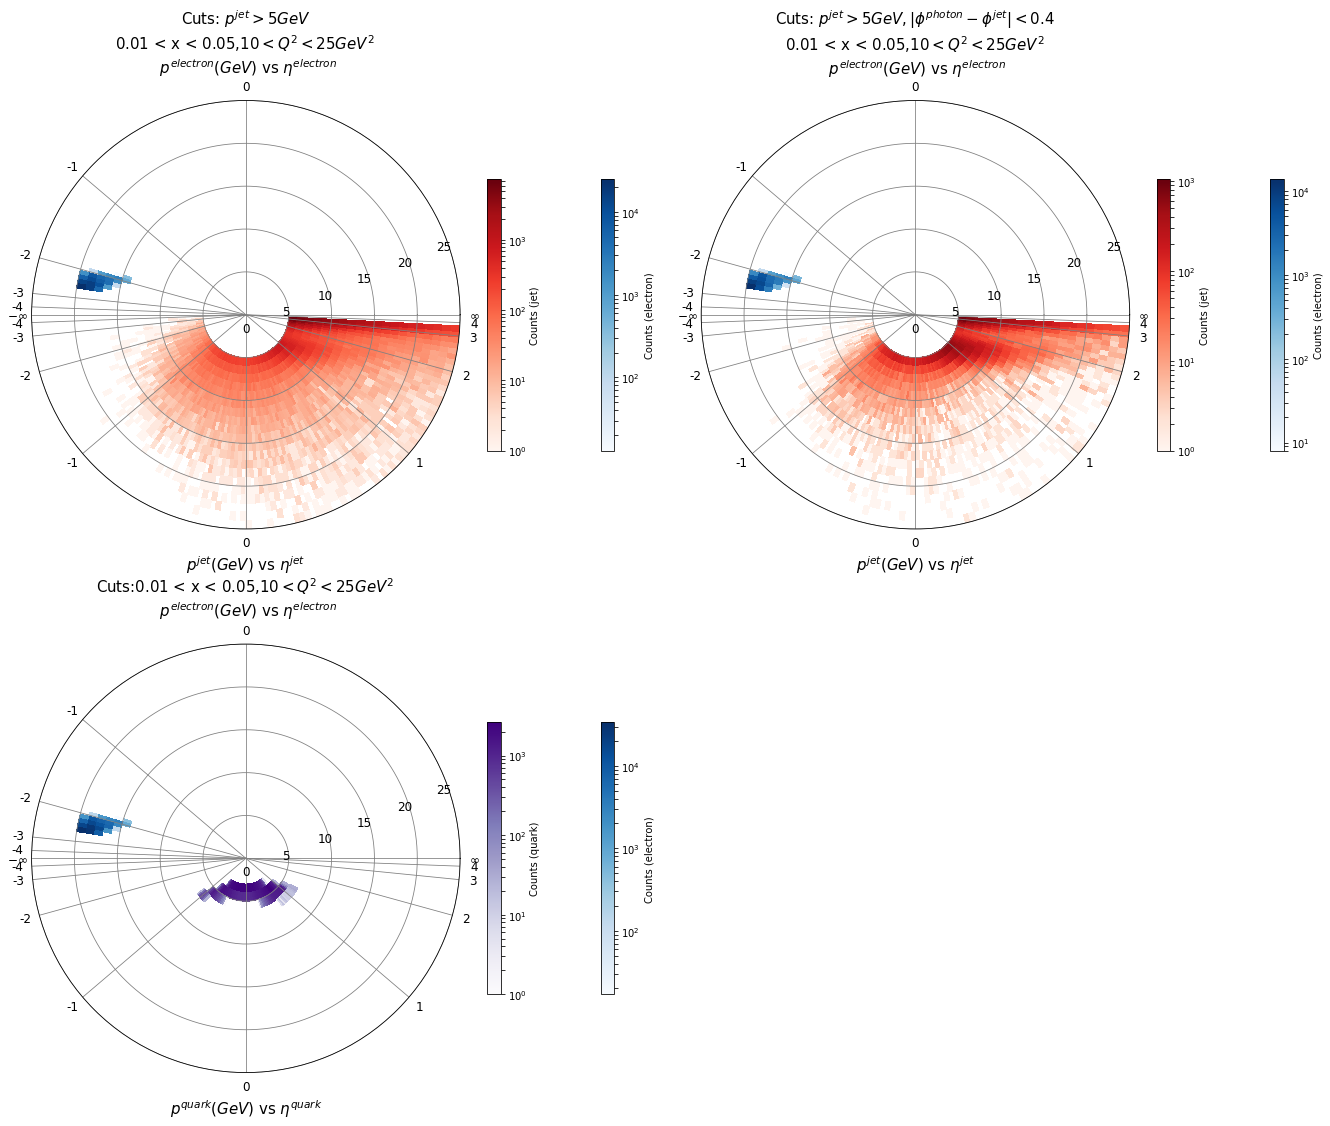

In [57]:
plot(1, 1, '10 < Q^2 < 25', '0.01 < x < 0.05', '10-25-01-05')


Remove extra jets 76736  fraction kept: 59.0

Remove extra jets 55826  fraction kept: 92.7


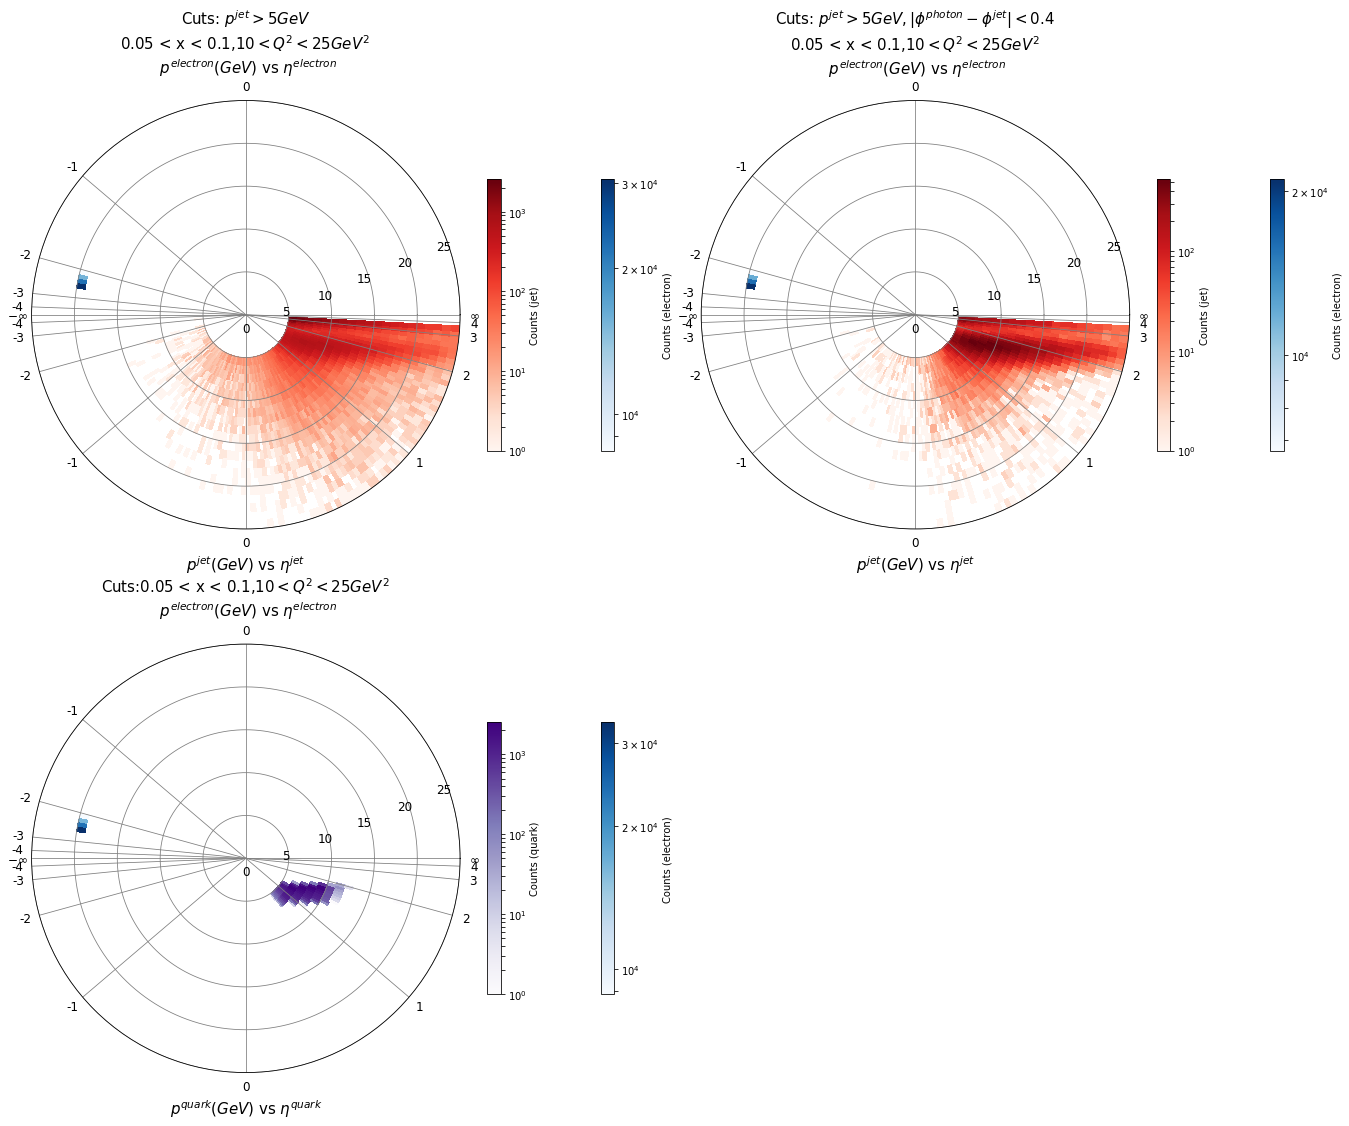

In [58]:
plot(1, 2, '10 < Q^2 < 25', '0.05 < x < 0.1', '10-25-05-1')


Remove extra jets 64787  fraction kept: 60.3

Remove extra jets 50360  fraction kept: 94.3


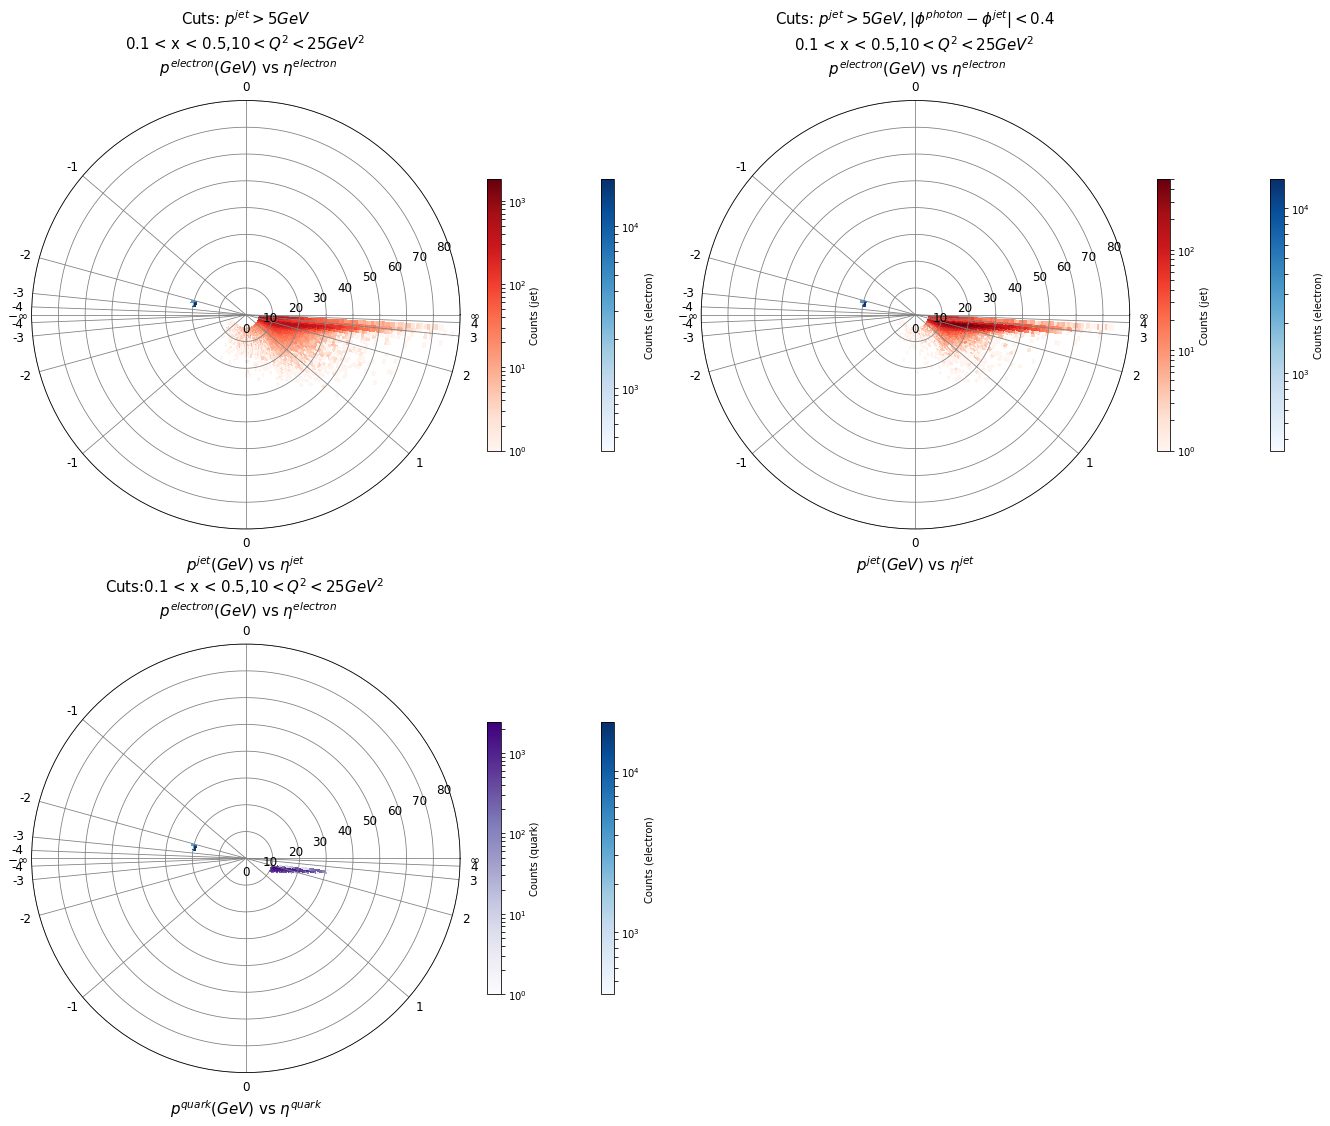

In [59]:
plot(1, 3, '10 < Q^2 < 25', '0.1 < x < 0.5', '10-25-1-5')


Remove extra jets 9429  fraction kept: 58.0

Remove extra jets 7612  fraction kept: 92.6


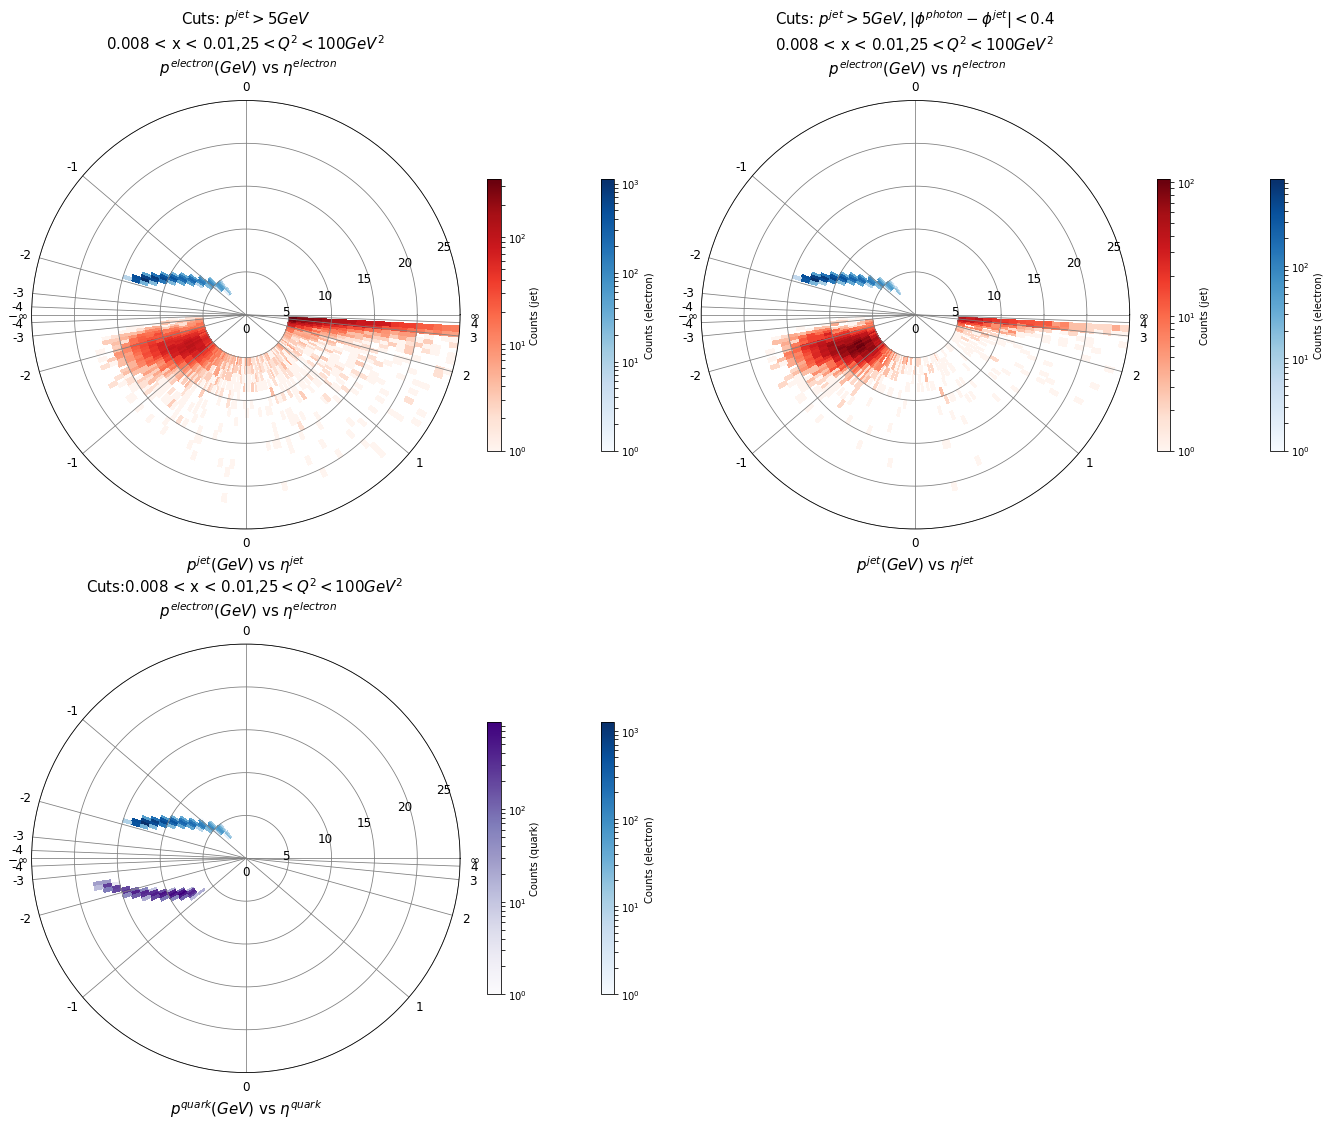

In [60]:
plot(2, 0, '25 < Q^2 < 100', '0.008 < x < 0.01', '25-100-008-01')


Remove extra jets 86290  fraction kept: 57.9

Remove extra jets 68705  fraction kept: 92.2


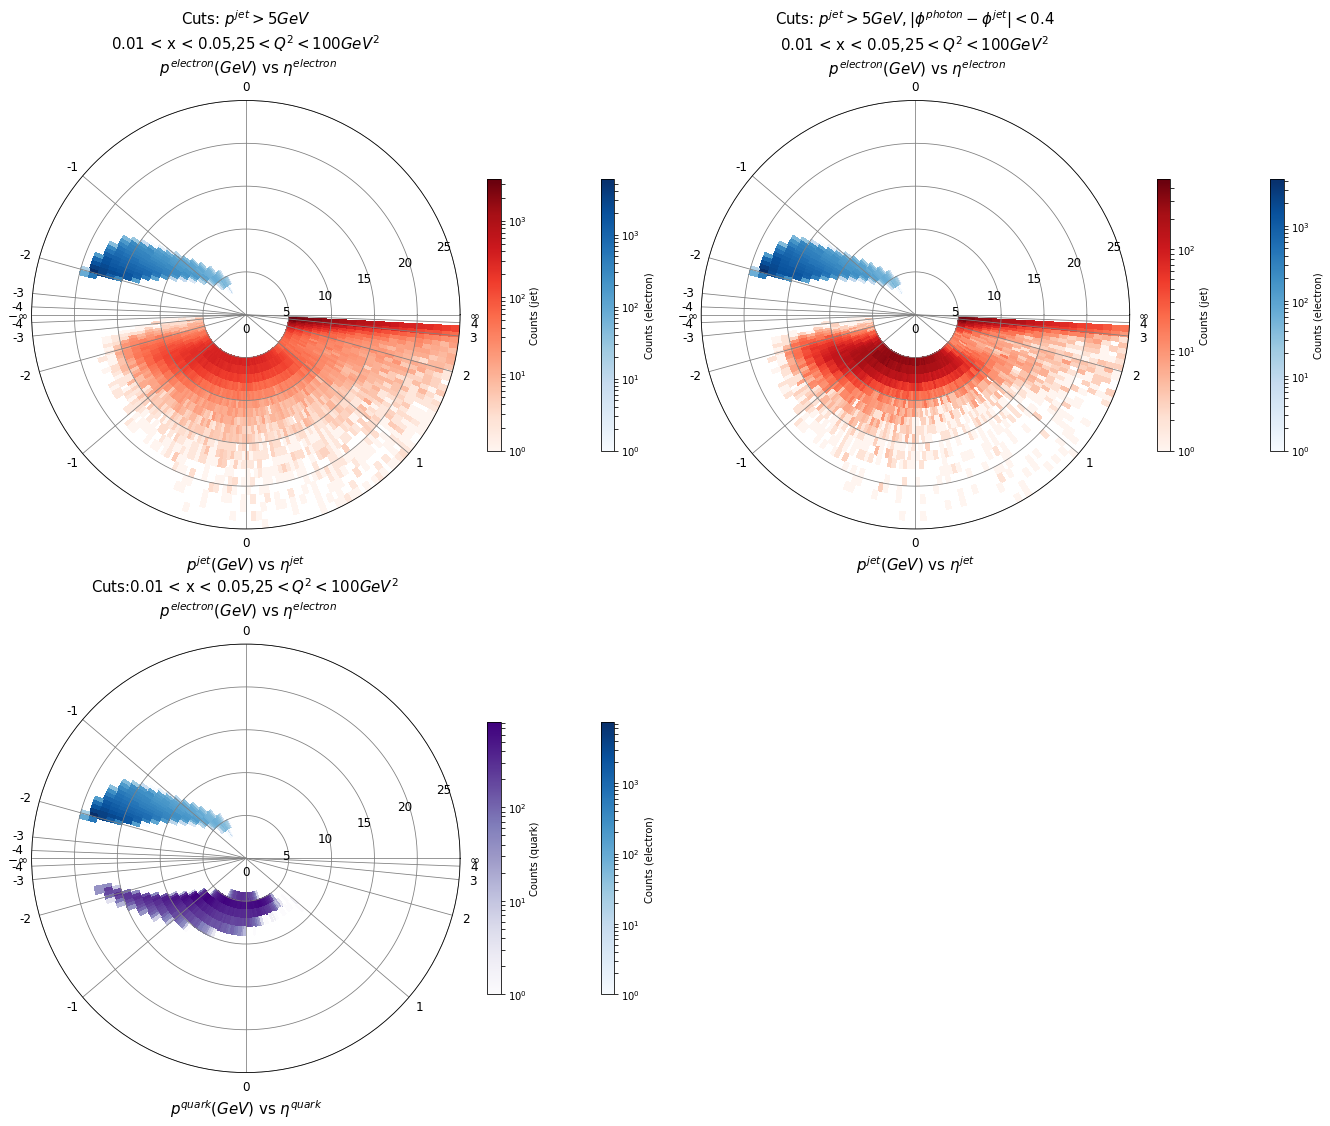

In [61]:
plot(2, 1, '25 < Q^2 < 100', '0.01 < x < 0.05', '25-100-01-05')


Remove extra jets 40025  fraction kept: 57.1

Remove extra jets 34989  fraction kept: 90.1


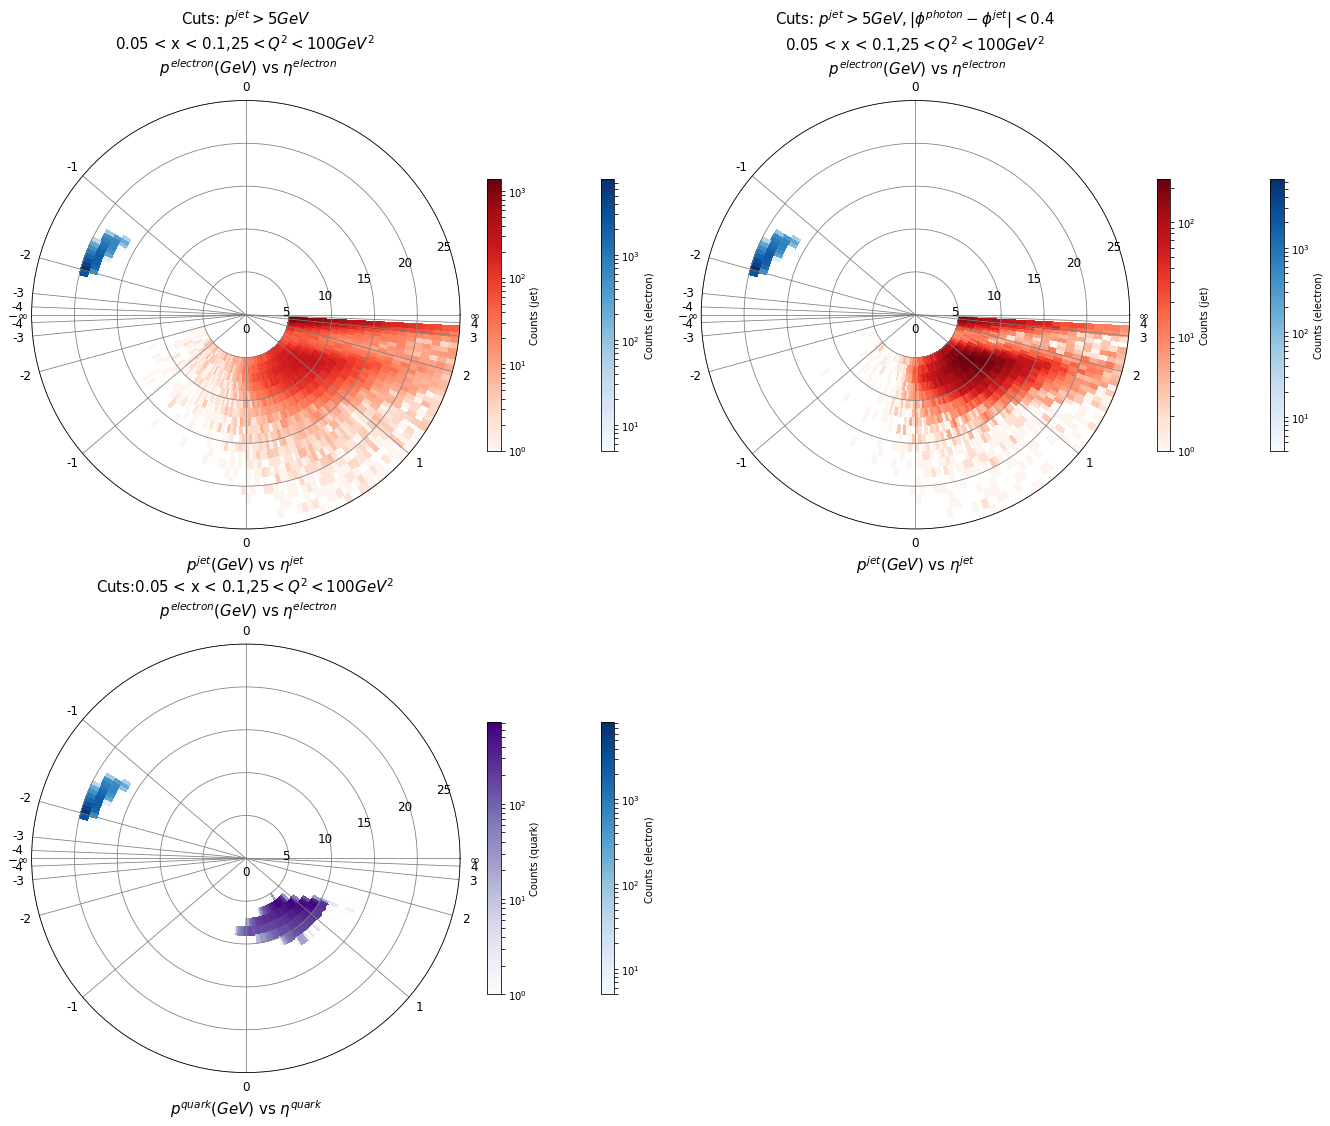

In [62]:
plot(2, 2, '25 < Q^2 < 100', '0.05 < x < 0.1', '25-100-05-1')


Remove extra jets 64087  fraction kept: 59.9

Remove extra jets 57661  fraction kept: 92.1


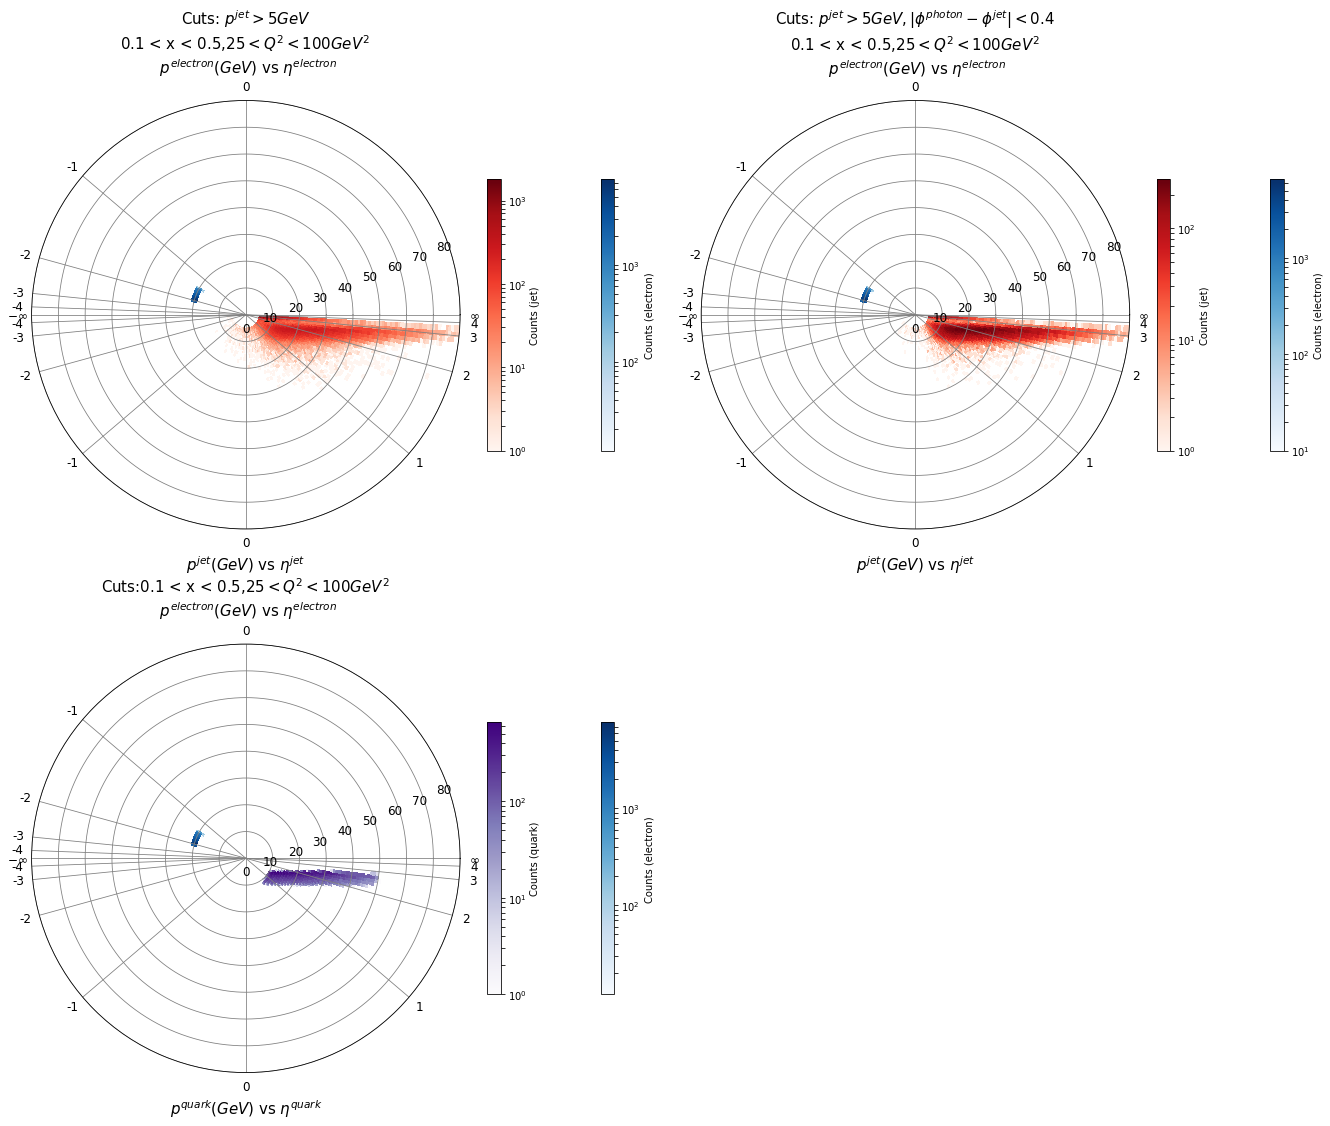

In [63]:
plot(2, 3, '25 < Q^2 < 100', '0.1 < x < 0.5', '25-100-1-5')


Remove extra jets 8156  fraction kept: 55.5

Remove extra jets 7835  fraction kept: 90.5


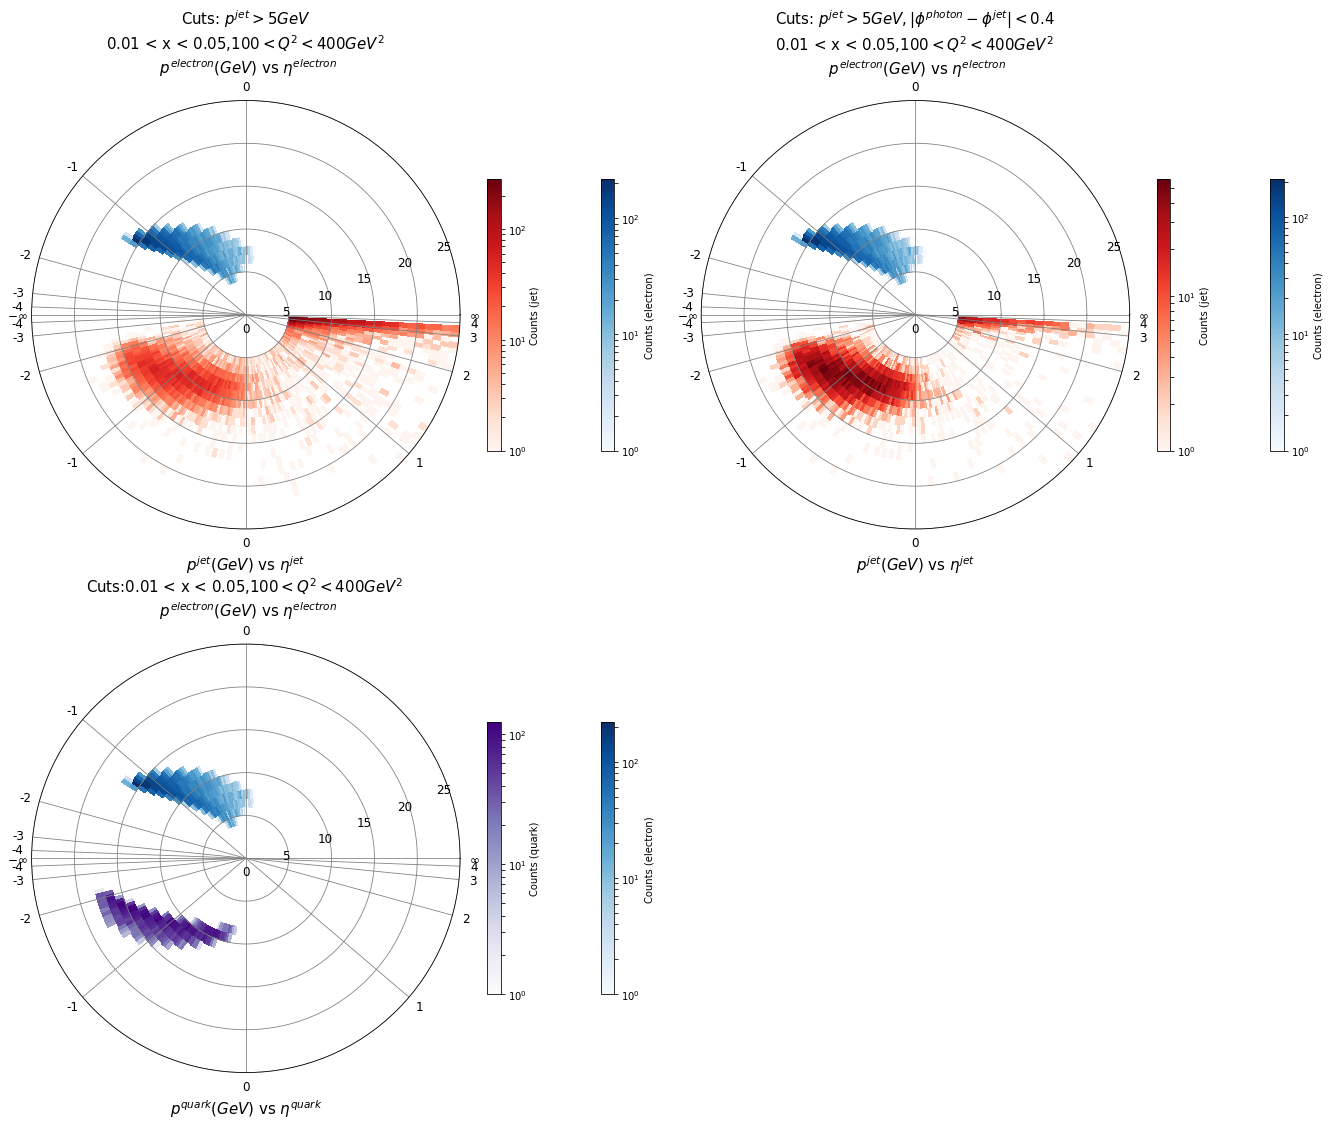

In [64]:
plot(3, 1, '100 < Q^2 < 400', '0.01 < x < 0.05', '100-400-01-05')


Remove extra jets 8524  fraction kept: 56.5

Remove extra jets 8252  fraction kept: 89.5


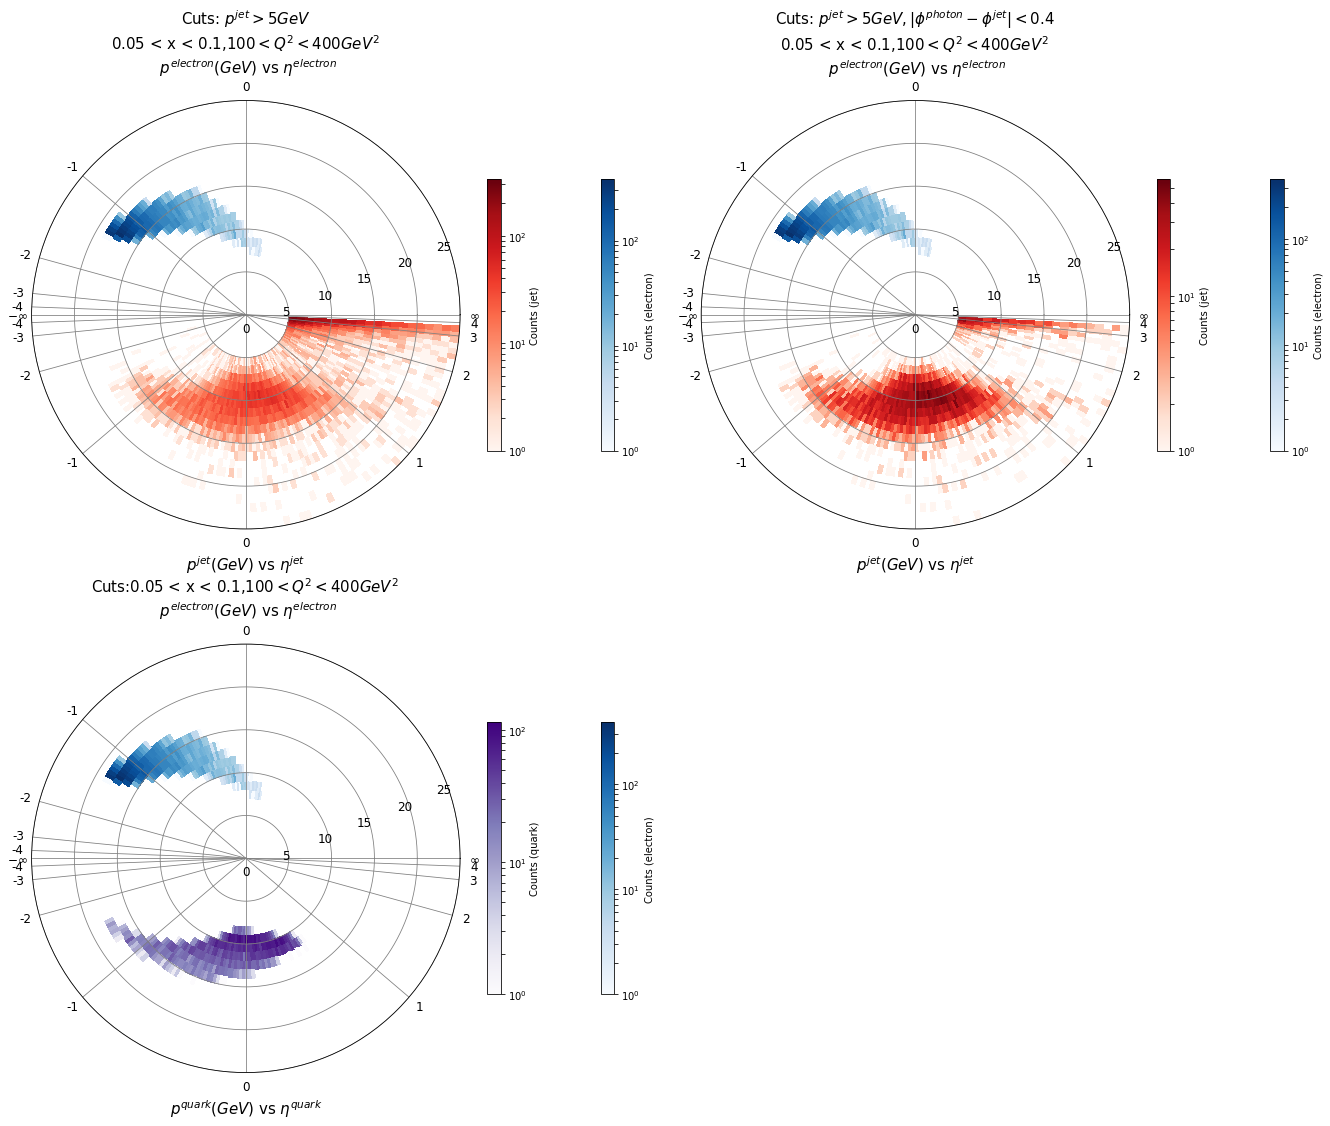

In [65]:
plot(3, 2, '100 < Q^2 < 400', '0.05 < x < 0.1', '100-400-05-1')


Remove extra jets 14881  fraction kept: 58.0

Remove extra jets 14470  fraction kept: 88.7


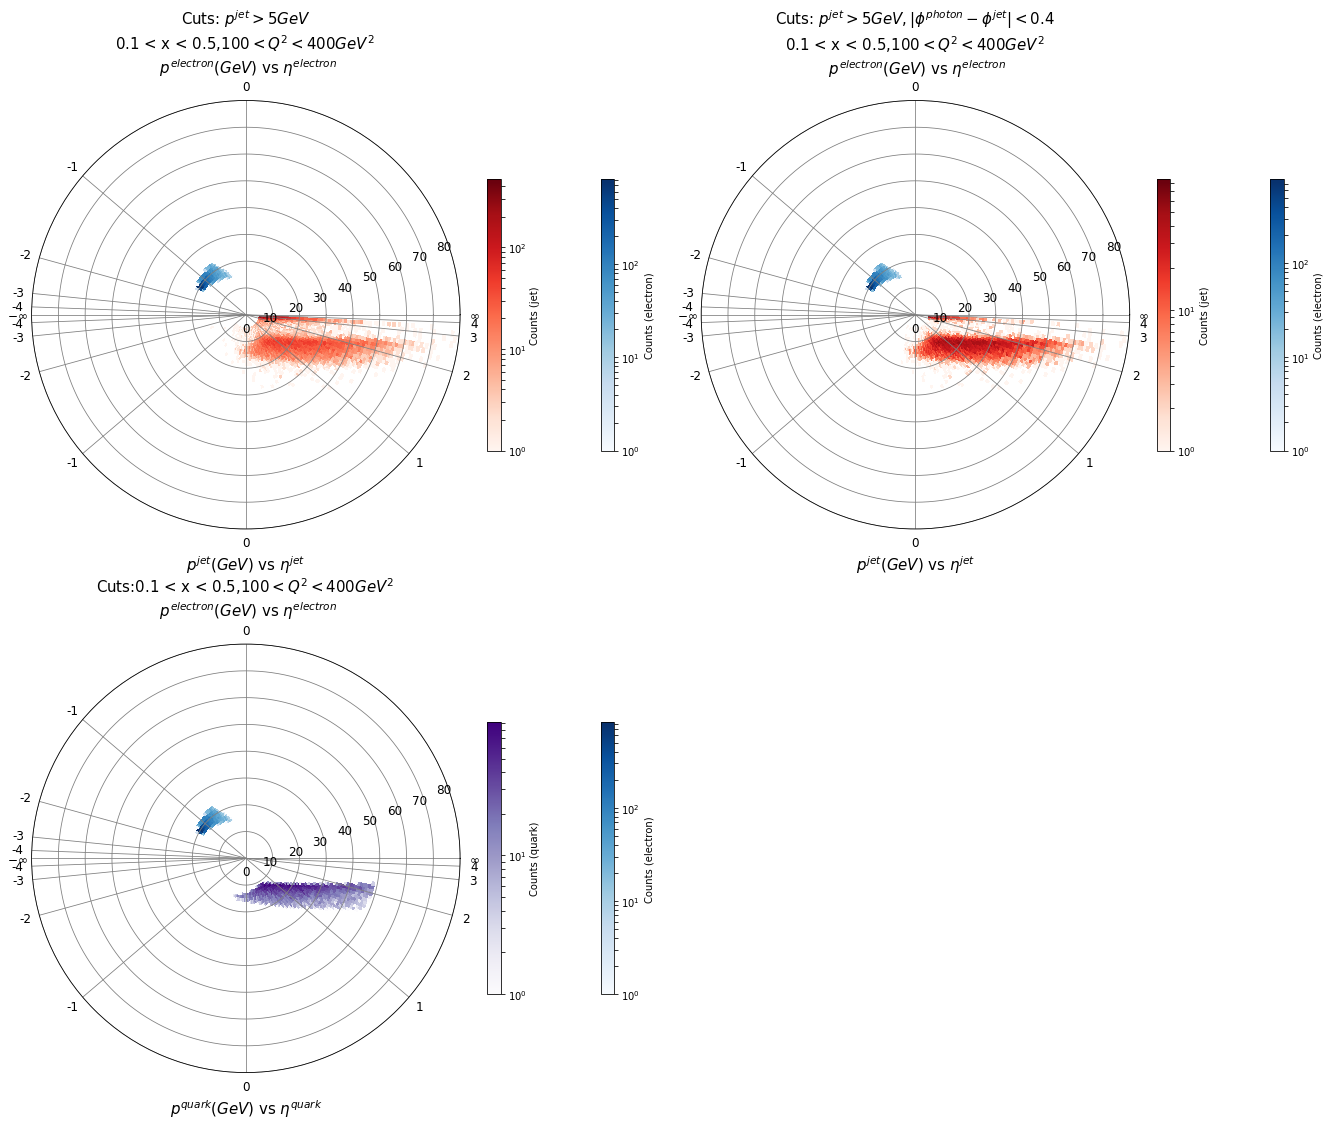

In [66]:
plot(3, 3, '100 < Q^2 < 400', '0.1 < x < 0.5', '100-400-1-5')


Remove extra jets 340  fraction kept: 53.4

Remove extra jets 336  fraction kept: 87.7


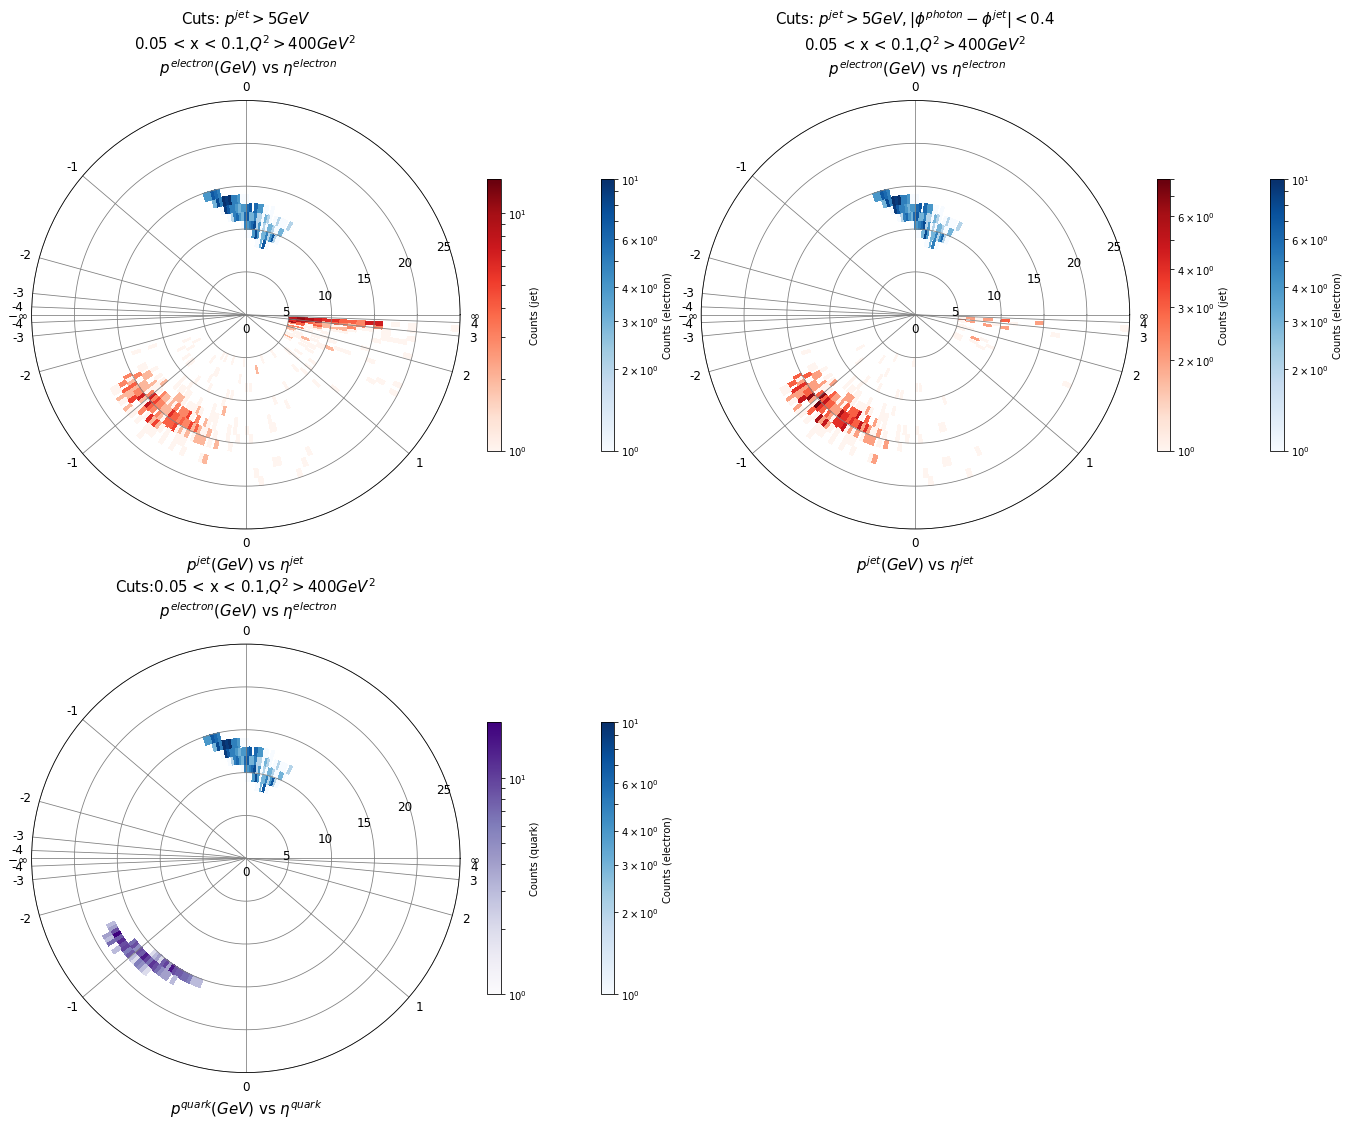

In [67]:
plot(4, 2, 'Q^2 > 400', '0.05 < x < 0.1', '400-05-1')


Remove extra jets 2495  fraction kept: 57.9

Remove extra jets 2483  fraction kept: 88.2


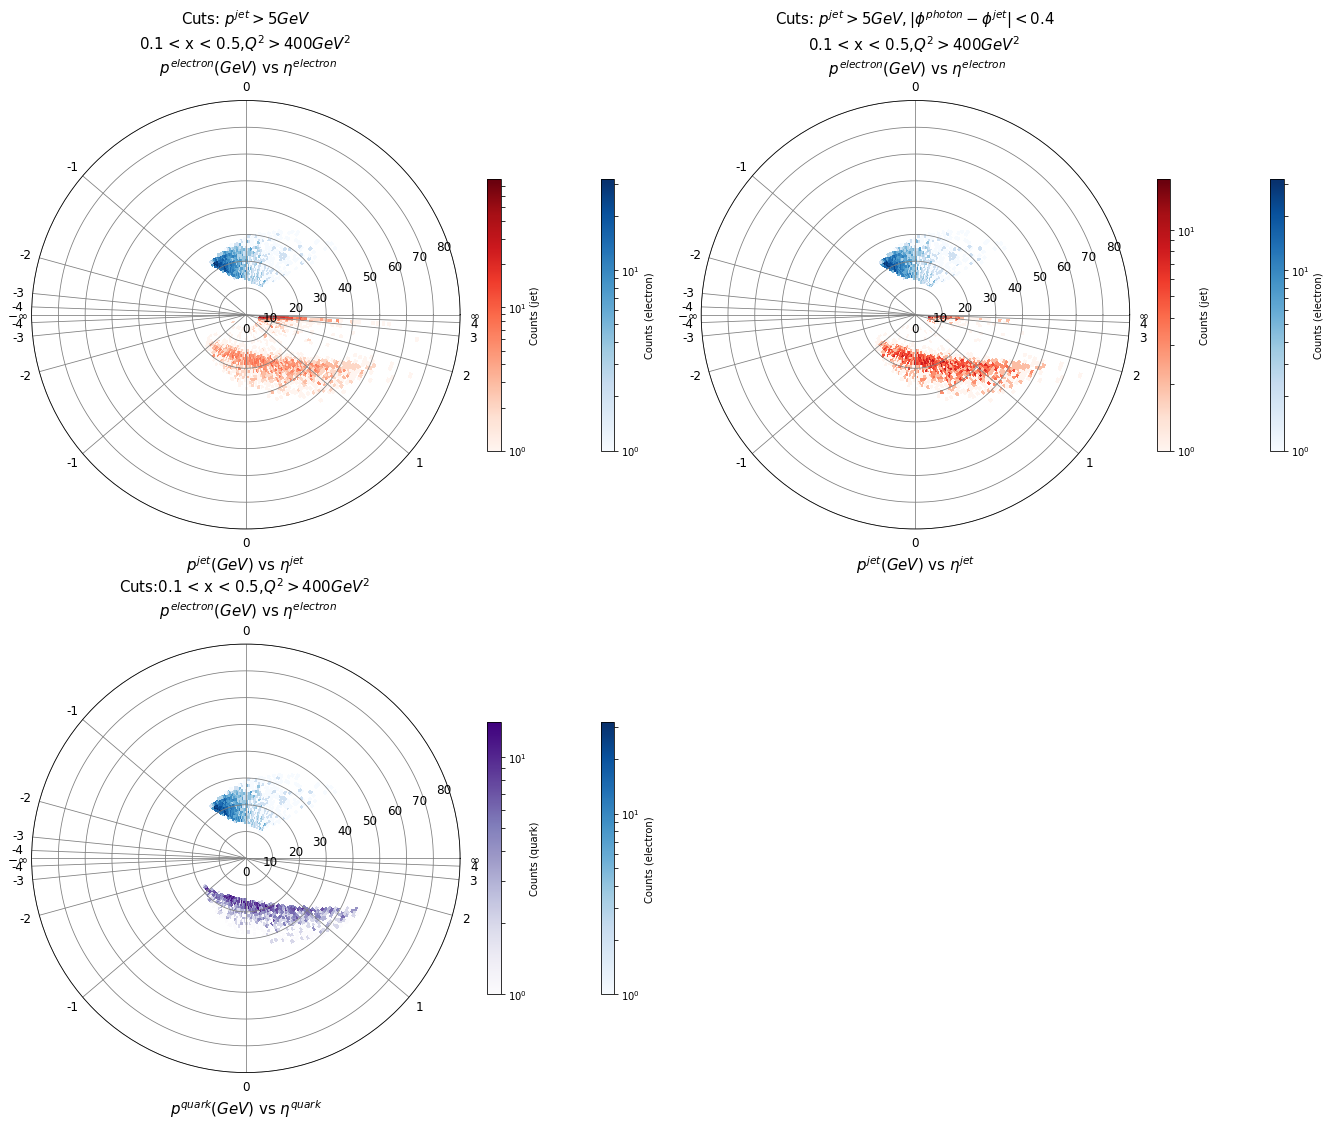

In [68]:
plot(4, 3, 'Q^2 > 400', '0.1 < x < 0.5', '400-1-5')